In [32]:
!pip install surprise
!pip install sentence-transformers

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Recommender system for books: Modelisation

In [34]:
# Data manipulation
import pandas as pd 
import numpy as np 
import gc

# Graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Modelisation libraries
from surprise import BaselineOnly, SVD, NMF, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import Dataset
from surprise import Reader

from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
path = '/content/drive/My Drive/Ingénieur ML - OC/P7/Datasets/'

In [ ]:
# Importing data about users and books 
users = pd.read_parquet(path+"users_data_cleaning.parquet.gzip")
books = pd.read_parquet(path+"books_data_cleaning.parquet.gzip")

It exists different kinds of recommender engines. In this proof of concept, simple recommender, user based collaborative filtering, content-based recommender and hybrid methods will be testing to find the best recommender engines. 

## 1) Simple recommender

Simple recommender is the most basic recommender engines. It based on popularity. To calcule it, rating and number of reviews are used. The formula used in the following is the formula used by the IMDB website to calcule.  

*Source:* https://www.datacamp.com/community/tutorials/recommender-systems-python

In [ ]:
# creating a new dataset for the calculus
simple_reco = books.copy()
simple_reco = simple_reco[["Id", "Name", "Authors",
                           "Rating", "CountsOfReview"]]
simple_reco.head()

,Id,Name,Authors,Rating,CountsOfReview
0,4000063,The Flintstones in Viva Rock Vegas,Ellen Miles,3.82,1
1,4000100,Little Rhody,Neta Lohnes Frazier,4.33,1
2,4000228,Finance And Investments Using The Wall Street ...,Peter R. Crabb,0.00,0
3,4000366,Shorty McCabe Looks 'Em Over,Sewell Ford,0.00,0
4,4000441,Plant Pathology,George N. Agrios,4.52,0


In [ ]:
# calculating the average rating
C = simple_reco['Rating'].mean()
print(C)

3.7320950652695215


In [ ]:
# calculating and keeping
# books with the 90th percentile
m = simple_reco['CountsOfReview'].quantile(0.90)
print(m)

41.0


In [ ]:
# selecting only books with at least 41 reviews
q_books = simple_reco.copy().loc[simple_reco['CountsOfReview'] >= m]
q_books.shape

(12116, 5)

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['CountsOfReview']
    R = x['Rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
q_books['score'] = q_books.apply(weighted_rating, axis=1)

In [ ]:
#Sort movies based on score calculated above
q_books = q_books.sort_values('score', ascending=False)

#Print the top 15 books
q_books[["Id",'Name', "Authors", 'CountsOfReview', 'Rating', 'score']].head(20)

,Id,Name,Authors,CountsOfReview,Rating,score
44289,862041,"Harry Potter Series Box Set (Harry Potter, #1-7)",J.K. Rowling,6522,4.74,4.733703
40413,818056,Harry Potter and the Deathly Hallows (Harry Po...,J.K. Rowling,952,4.62,4.583339
115327,1215032,"The Wise Man's Fear (The Kingkiller Chronicle,...",Patrick Rothfuss,16523,4.57,4.567926
61446,3165162,Percy Jackson and the Olympians (Percy Jackson...,Rick Riordan,546,4.59,4.530078
72565,1025685,"The Absolute Sandman, Volume Two",Neil Gaiman,198,4.69,4.525673
91715,2495562,The Wise Man's Fear (The Kingkiller Chronicle...,Patrick Rothfuss,488,4.56,4.495833
82953,2186848,"The Absolute Sandman, Volume Three",Neil Gaiman,140,4.71,4.488486
98149,2767793,"The Hero of Ages (Mistborn, #3)",Brandon Sanderson,10101,4.49,4.486936
30441,1179967,"A Storm of Swords (A Song of Ice and Fire, #3)",George R.R. Martin,583,4.54,4.486917
66035,3362870,"The Hero of Ages (Mistborn, #3)",Brandon Sanderson,1289,4.49,4.466636


In [ ]:
print(np.sqrt(mean_squared_error(q_books['Rating'],
                                 q_books["score"])))

0.10848119654754877


In [ ]:
del q_books, simple_reco
gc.collect()

162

## 2) User-based collaborative filtering

### a) Preparing the data for Surprise library

In [ ]:
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(users[['User_Id', 'Id', 'Rating']], reader)

In [ ]:
trainset, testset = train_test_split(data_surprise, test_size=.2)

In [ ]:
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
base_als = BaselineOnly(bsl_options=bsl_options)
predictions = base_als.fit(trainset).test(testset)

Estimating biases using als...


In [ ]:
del predictions
gc.collect()

50

In [ ]:
bsl_options = {'method': 'sgd',
               'learning_rate': .00005,
               }
base_sgd = BaselineOnly(bsl_options=bsl_options)
predictions = base_sgd.fit(trainset).test(testset)

Estimating biases using sgd...


In [ ]:
del predictions
gc.collect()

50

### b) Matrix Factorization based algorithms

In [ ]:
svd = SVD()
nmf = NMF()

In [ ]:
model = [svd, nmf]
dict_model = {}

for model in model:
    y_pred = model.fit(trainset).test(testset)
    rmse = accuracy.rmse(y_pred)
    dict_model[model] = rmse.round(3)

print(dict_model)

RMSE: 0.7645
RMSE: 0.8746
{<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fd27c0d9250>: 0.765, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7fd27c0d9510>: 0.875}


In [ ]:
param_grid = {'n_factors': [50, 75, 100, 125],
              'n_epochs': [5, 10, 15, 20, 25], 
              'lr_all': [0.001, 0.002, 0.005, 0.1],
              'reg_all': [0.1, 0.2, 0.4, 0.6],
              'random_state' : [42]
}

gs = GridSearchCV(SVD,
                  param_grid,
                  measures=['rmse', 'mae'],
                  cv=5)

gs.fit(data_surprise)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.7493125264355076
{'n_factors': 125, 'n_epochs': 25, 'lr_all': 0.1, 'reg_all': 0.1, 'random_state': 42}


In [ ]:
tracker = EmissionsTracker()
svd_gs = gs.best_estimator['rmse']

tracker.start()
predictions = svd_gs.fit(trainset).test(testset)
emissions = tracker.stop()

accuracy.rmse(predictions)
print("GHG emission:", emissions)

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.
/usr/local/lib/python3.7/dist-packages/apscheduler/util.py:95: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  if obj.zone == 'local':
/usr/local/lib/python3.7/dist-packages/apscheduler/triggers/interval.py:66: PytzUsageWarning: The normalize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  return self.timezone.normalize(next_fire_time)


RMSE: 0.7488
GHG emission: 4.335452887905336e-05


In [ ]:
del predictions,\
    gs,\
    dict_model,\
    emissions,\
    tracker
gc.collect()

50

### c) K-NN based models

In [ ]:
# Initializing similarities options
sim_options = {'name': 'cosine',
               'user_based': True  # compute  similarities between users
               }

In [ ]:
knnbasic = KNNBasic()
knnmeans = KNNWithMeans()
knnzscore = KNNWithZScore()

In [ ]:
model = [knnbasic, knnmeans, knnzscore]
dict_model = {}

for model in model:
    y_pred = model.fit(trainset).test(testset)
    rmse = accuracy.rmse(y_pred)
    dict_model[model] = rmse.round(3)

print(dict_model)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7657
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7677
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7594
{<surprise.prediction_algorithms.knns.KNNBasic object at 0x7fd26da56fd0>: 0.766, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7fd26da56610>: 0.768, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x7fd26da56d50>: 0.759}


In [ ]:
param_grid = {'k': [20, 30, 40, 50, 60, 70, 80]}

gs = GridSearchCV(KNNWithZScore,
                  param_grid,
                  measures=['rmse', 'mae'],
                  cv=5)

gs.fit(data_surprise)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [ ]:
knn_gs = gs.best_estimator['rmse']

tracker = EmissionsTracker()

tracker.start()
predictions = knn_gs.fit(trainset).test(testset)
emissions = tracker.stop()


accuracy.rmse(predictions)
print("GHG emission:", emissions)

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.
/usr/local/lib/python3.7/dist-packages/apscheduler/util.py:95: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  if obj.zone == 'local':
/usr/local/lib/python3.7/dist-packages/apscheduler/triggers/interval.py:66: PytzUsageWarning: The normalize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  return self.timezone.normalize(next_fire_time)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7411
GHG emission: 3.080626557486469e-05


In [ ]:
del gs,\
    dict_model,\
    predictions,\
    tracker,\
    emissions
gc.collect()

281

## 3) Content-based algorithms

### a) With Tfidf

https://medium.com/analytics-vidhya/content-based-recommender-systems-in-python-2b330e01eb80

In [ ]:
desc = books.copy()
desc = desc[["Id", "Name", "Authors", "Description"]]

In [ ]:
desc = desc.sample(frac=.3,
                   random_state=42)

In [ ]:
desc.reset_index(inplace=True)
desc.drop("index", axis=1, inplace=True)

In [ ]:
tracker = EmissionsTracker()
tracker.start()

tfidf = TfidfVectorizer(stop_words='english')
desc['Description'] = desc['Description'].fillna("")
descr_matrix = tfidf.fit_transform(desc['Description'])
similarity_matrix = linear_kernel(descr_matrix, descr_matrix)

emissions = tracker.stop()
print("GHG Emissions:", emissions)

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.
/usr/local/lib/python3.7/dist-packages/apscheduler/util.py:95: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  if obj.zone == 'local':
/usr/local/lib/python3.7/dist-packages/apscheduler/triggers/interval.py:66: PytzUsageWarning: The normalize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  return self.timezone.normalize(next_fire_time)
/usr/local/lib/python3.7/dist-packages/apscheduler/triggers/interval.py:66: PytzUsageWarning: The normalize method is no longer necessary, as t

GHG Emissions: 9.104574043705296e-05


In [ ]:
mapping = pd.Series(desc.index,
          index = desc['Name'])
print(mapping)

Name
On the Other Side of Mount Ararat: A Story of a Vanished City        0
The Tall Uncut: Stories                                              1
Heart Essence of the Vast Expanse: A Story of Transmission           2
Don't Look a Ghost Horse in the Mouth                                3
Turpentine                                                           4
                                                                 ...  
Junie B. Jones Is Not a Crook (Junie B. Jones, #9)               35869
The Rabbits' Wedding                                             35870
Calling the Shots (Angels Unlimited, #4)                         35871
Crimson: Loyalty and Loss - Tome 1 (Crimson, #1)                 35872
The Letterboxer's Companion                                      35873
Length: 35874, dtype: int64


In [ ]:
def recommend_books(book_input):
    print("Book Read: ", book_input)
    book_index = mapping[book_input]
    #get similarity values with other books
    #similarity_score is the list of index and similarity matrix
    similarity_score = list(enumerate(similarity_matrix[book_index]))
    #sort in descending order the similarity score of movie inputted with all the other books
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 20 most similar books. Ignore the first book.
    similarity_score = similarity_score[1:20]
    
    #return book names using the mapping series
    book_indices = [i[0] for i in similarity_score]
    return (desc['Name'].iloc[book_indices])

In [ ]:
recommend_books('Pet Sematary')

3230                                  Black Cat, Volume 11
15651    Glimpses of Maine's Angling Past (Images of Am...
18878                        Oh, the Thinks You Can Think!
29986                                   Flags of the World
14474                           Go to the Room of the Eyes
663      Boston and the American Revolution: Boston Nat...
9972                                                   Ash
10932               True Blue (Sweet Valley Jr. High, #18)
8047     African American Life in the Rural South, 1900...
18362                                            Bold Wolf
24630                                       Cats from Away
25142                                        Isis Unveiled
7174                                       White House Q&A
34346                                  Night Winds Calling
30806            Among Other Things, I've Taken Up Smoking
31803    Changing Family Values: Difference, Diversity ...
29656                   The Funeral Makers (Mattagash, #

In [ ]:
del tracker, emissions
gc.collect()

205

### b) Using Transformers

https://towardsdatascience.com/hands-on-content-based-recommender-system-using-python-1d643bf314e4

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

In [ ]:
data = pd.read_parquet(path+"books_with_complete_description.parquet.gzip")
data = data[["Name", "Authors", "Description"]].sample(frac=.3, random_state=42)
data.reset_index(inplace=True)
data.drop("index", axis=1, inplace=True)
data.head()

,Name,Authors,Description
0,On the Other Side of Mount Ararat: A Story of ...,Mariam Manoukian,On the Other Side of Mount Ararat is the story...
1,The Tall Uncut: Stories,Pete Fromm,"In this honest, contemporary collection of sho..."
2,Heart Essence of the Vast Expanse: A Story of ...,Anne Carolyn Klein,"Beautiful, evocative, and eminently useful, th..."
3,Don't Look a Ghost Horse in the Mouth,George E. Stanley,The horse Emily brags about to her classmates ...
4,Turpentine,Spring Warren,A comic glance at the old American West and a ...


In [ ]:
X = np.array(data["Description"])

In [ ]:
text_data = X

tracker = EmissionsTracker()
tracker.start()

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text_data, show_progress_bar=True)
X = np.array(embeddings)
cos_sim_data = pd.DataFrame(cosine_similarity(X))

emissions = tracker.stop()
print("GHG Emissions:", emissions)

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.
/usr/local/lib/python3.7/dist-packages/apscheduler/util.py:95: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  if obj.zone == 'local':
/usr/local/lib/python3.7/dist-packages/apscheduler/triggers/interval.py:66: PytzUsageWarning: The normalize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  return self.timezone.normalize(next_fire_time)


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1122 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/apscheduler/triggers/interval.py:66: PytzUsageWarning: The normalize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  return self.timezone.normalize(next_fire_time)


GHG Emissions: 0.000699834685405908


In [ ]:
n_comp = 5
pca = PCA(n_components=n_comp)
pca.fit(X)
pca_data = pd.DataFrame(pca.transform(X))
pca_data.head()

,0,1,2,3,4
0,-0.502564,-1.346518,0.027566,-5.452170,-2.813500
1,-4.667008,0.089642,0.203640,-0.871298,-2.342319
2,5.274408,-1.781673,-0.960317,1.348200,2.225788
3,-3.865516,-3.019298,3.261770,0.450566,-1.398077
4,-2.521324,1.162171,-1.456954,-0.492481,-0.561697


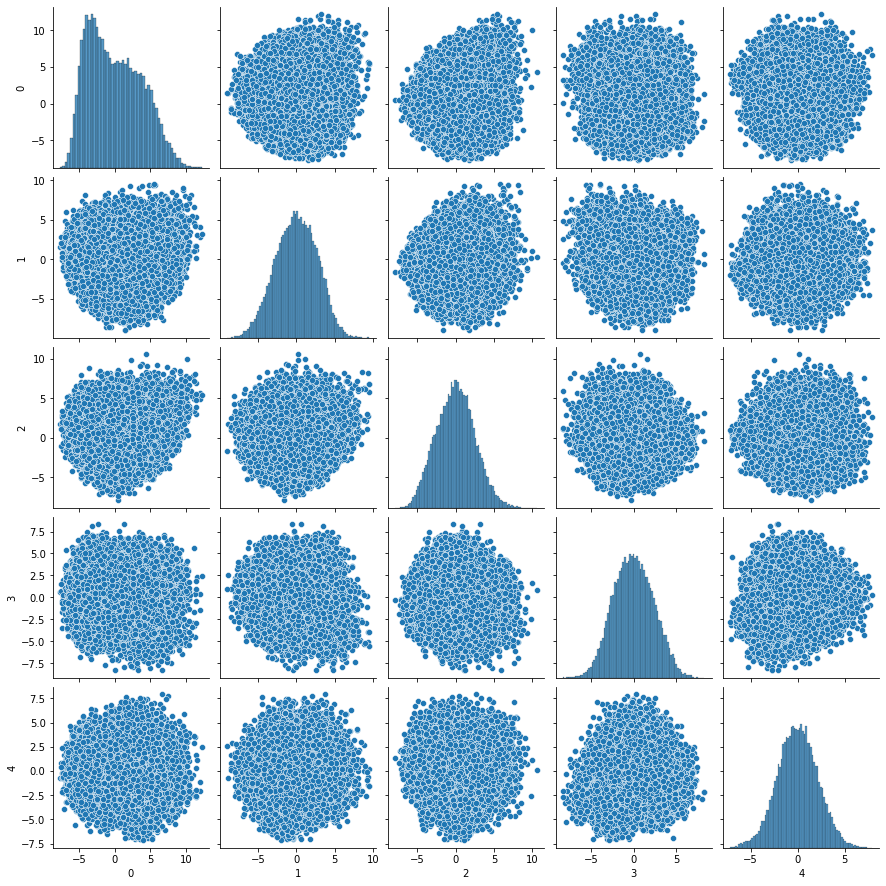

In [ ]:
sns.pairplot(pca_data)

In [ ]:
data.loc[data["Authors"] == "Stephen King"]

,Name,Authors,Description
1952,The Shining,Stephen King,Jack Torrance's new job at the Overlook Hotel ...
2372,"The Waste Lands (The Dark Tower, #3)",Stephen King,The Last Gunslinger moves ever closer to the D...
3326,The Dark Half,Stephen King,Thad Beaumont is a Pulitzer Prize-winning auth...
4087,The Dead Zone (Charnwood Library),Stephen King,"Johnny Smith has had a terrible accident, and ..."
5337,"The Green Mile, Part 3: Coffey's Hands",Stephen King,The electric chair is the focus of a chilling ...
6432,Danse macabre,Stephen King,"In the fall of 1978, Stephen King taught at th..."
7037,"Four Past Midnight, Vol. 2",Stephen King,Straight up midnight : an introductory note --...
8027,"The Gunslinger (The Dark Tower, #1)",Stephen King,4 cass. : 6 hr<br />Filled with ominous landsc...
8149,The Talisman,Stephen King,The bestselling collaboration of two masters o...
8401,The Gunslinger,Stephen King,Since the publication of THE GUNSLINGER in an ...


In [ ]:
def give_recommendations(index, print_recommendation = False,print_recommendation_plots= False):
  index_recomm =cos_sim_data.loc[index].sort_values(ascending=False).index.tolist()[1:6]
  books_recomm =  data['Name'].loc[index_recomm].values
  result = {'Books':books_recomm,'Index':index_recomm}
  if print_recommendation==True:
    print('Book Read: %s \n'%(data['Name'].loc[index]))
    k=1
    for book in books_recomm:
      print('Recommended book #%i : %s \n'%(k, book))
      k = k+1
  if print_recommendation_plots==True:
    print('Book Read - Description:\n %s \n'%(data['Description'].loc[index]))
    k=1
    for q in range(len(books_recomm)):
      plot_q = data['Description'].loc[index_recomm[q]]
      print('Recommended Book #%i - Description:\n %s \n'%(k,plot_q))
      k=k+1
  return result

In [ ]:
give_recommendations(19590, True, True)

Book Read: Pet Sematary 

Recommended book #1 : The Conways (Images of America: New Hampshire) 

Recommended book #2 : The Communities of Western Aroostook County (Images of America: Maine) 

Recommended book #3 : We Keep a Light 

Recommended book #4 : Mary had a little lamb 

Recommended book #5 : Common Ground: A Naturalist's Cape Cod 

Book Read - Description:
 The Creeds were an ideal family. When they found the old house in rural Maine, they thought it was too good to be true. It was. 

Recommended Book #1 - Description:
 The Conway area has long held an important place in the history of New Hampshire. The earliest settlers found land both fertile and beautiful, and lived a basic existence amidst the hills and dales of the Mount Washington Valley. The outstanding natural beauty of the Conway area also captured the hearts and minds of the creative community, and when artists of the White Mountain School began to share their paintings of the breathtaking panoramas around them, a to

{'Books': array(['The Conways (Images of America: New Hampshire)',
        'The Communities of Western Aroostook County (Images of America: Maine)',
        'We Keep a Light', 'Mary had a little lamb',
        "Common Ground: A Naturalist's Cape Cod"], dtype=object),
 'Index': [4668, 22459, 792, 21532, 891]}

In [ ]:
recomm_list = []
for i in range(len(X)):
  recomm_i = give_recommendations(i)
  recomm_list.append(recomm_i['Books'])
recomm_data = pd.DataFrame(recomm_list,columns=['First Recommendation','Second Recommendation','Third Recommendation','Fourth Recommendation','Fifth Recommendation'])
recomm_data['Books Read'] = data['Name']
recomm_data = recomm_data[['Books Read','First Recommendation','Second Recommendation','Third Recommendation','Fourth Recommendation','Fifth Recommendation']]

In [ ]:
recomm_data.sample(frac=1).head()

,Books Read,First Recommendation,Second Recommendation,Third Recommendation,Fourth Recommendation,Fifth Recommendation
23278,Researching Dance,Understanding Movies,The Art of Dance in Education,Organic Chemistry [with Organic ChemistryNOW A...,Looking at Movies: An Introduction to Film (wi...,An Assembly Language Introduction to Computer ...
31962,A Climber's Guide to the Teton Range,The High Himalaya,Climbing California's Fourteeners: 183 Routes ...,Hiking Montana,National Geographic Field Guide to the Birds o...,Yosemite National Park: A Complete Hiker's Guide
13087,Queen Rider,Sisters & Lovers,Home Before Dark,"England's Perfect Hero (Lessons in Love, #3)","Christina's Courage (Thoroughbred, #27)","Love's Magic (Boadicea, #1)"
23357,Chief Performance Officer: Measuring What Matt...,Internationalizing the Medium-sized Firm: A Co...,Monster Careers: Networking,The One Minute Manager,Business Communication Today,The Leadership Pill: The Missing Ingredient in...
32051,Methodology and Historiography of the Caribbea...,Critical Essays on Geoffrey Chaucer,Great Issues in Western Civilization,Serpents in the Sand: Essays in the Nonlinear ...,The Cambridge History of Medieval Political Th...,The Roman Era: The British Isles: 55 BC-AD 410


In [ ]:
del users,\
    books,\
    data
gc.collect()

4303

### 4) Hybrid algorithms

In [36]:
users = pd.read_parquet(path+"users_data_cleaning.parquet.gzip")
books = pd.read_parquet(path+"books_data_cleaning.parquet.gzip")
data = pd.read_parquet(path+"books_with_complete_description.parquet.gzip")

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = keras.Sequential(
    [
     layers.Embedding(),
     layers.Embedding(),
     layers.Embedding(),
     layers.BatchNormalization,

     layers.Dense(activation="leaky_relu"),
     layers.Dropout(0),
     layers.BatchNormalization(momentum=0.1, epsilon=1e-05,),

     layers.Dense(activation="leaky_relu"),
     layers.Dropout(.4),
     layers.BatchNormalization(momentum=0.1, epsilon=1e-05),

     layers.Dense(activation="leaky_relu"),
     layers.Dropout(.4),
     layers.BatchNormalization(momentum=0.1, epsilon=1e-05),

     layers.Dense(activation="sigmoid")

    ]